## Solution to KAGGLE CHALLENGE

#### PS, i had only 24 hours, so this is just something quick i did

In [1]:
#import relevant libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from itertools import cycle, islice
sns.set(style="white", context="talk")
import numpy as np
from datetime import date,timedelta
from sklearn.preprocessing import LabelEncoder
pd.pandas.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
#read in the applications data
app_record = pd.read_csv('data/application_record.csv')
app_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
#app_record=app_record.drop_duplicates(keep='first',subset='ID')

In [4]:
#read in the credits data
credit_record = pd.read_csv('data/credit_record.csv')
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
#credit_record=credit_record.drop_duplicates(keep='first',subset='ID')

In [6]:
len(app_record),len(credit_record)

(438557, 1048575)

In [7]:
#merge the 2 datasets
df = app_record.merge(credit_record,on='ID')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [8]:
#convert column names to lowercase
df.columns=df.columns.str.lower()

In [9]:
#check for missing data
df.isnull().sum()

id                          0
code_gender                 0
flag_own_car                0
flag_own_realty             0
cnt_children                0
amt_income_total            0
name_income_type            0
name_education_type         0
name_family_status          0
name_housing_type           0
days_birth                  0
days_employed               0
flag_mobil                  0
flag_work_phone             0
flag_phone                  0
flag_email                  0
occupation_type        240048
cnt_fam_members             0
months_balance              0
status                      0
dtype: int64

#### occupation type is the column that has missing values, and it has many missing values, which needs to be investigated as in why it has missing values

In [10]:
#generate the labels
def make_label(status):
    if status=='C' or status =='X' or status<'2':
        return 'Good'
    else:
        return 'Bad'

In [11]:
df['labels']=df['status'].apply(lambda x: make_label(x))

In [12]:
df.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,labels
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,Good
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C,Good
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C,Good
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C,Good
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C,Good


In [13]:
((df['labels'].value_counts()/len(df['labels']))*100)

Good    99.636371
Bad      0.363629
Name: labels, dtype: float64

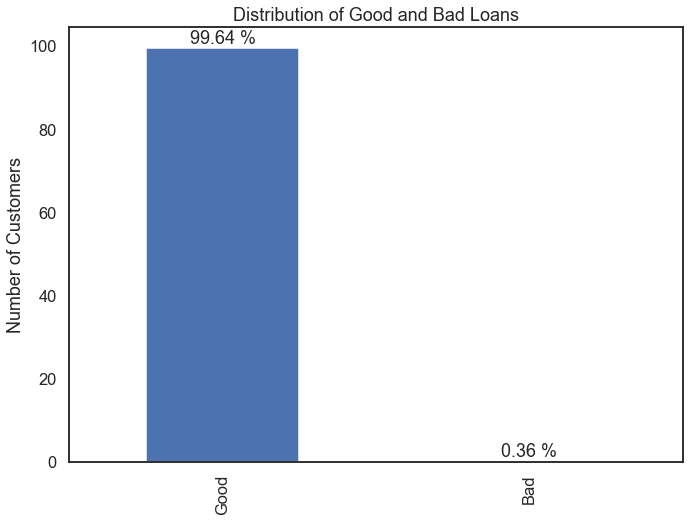

In [14]:
plt.figure(figsize=(11,8))
ax = (df['labels'].value_counts()/len(df['labels'])*100).plot.bar(rot=90)
ax.bar_label(ax.containers[0], fmt='%.2f %%')
ax.margins(x=12)
plt.ylabel('Number of Customers')
plt.title('Distribution of Good and Bad Loans')
plt.show()

#### 1 refers to individuals that have good loans, and 0 refers to individuals that have bad loans
#### There is a huge imbalance in the dataset, which needs to be taken care of

In [15]:
df.head(2)

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,labels
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,Good
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C,Good


<AxesSubplot:xlabel='code_gender', ylabel='count'>

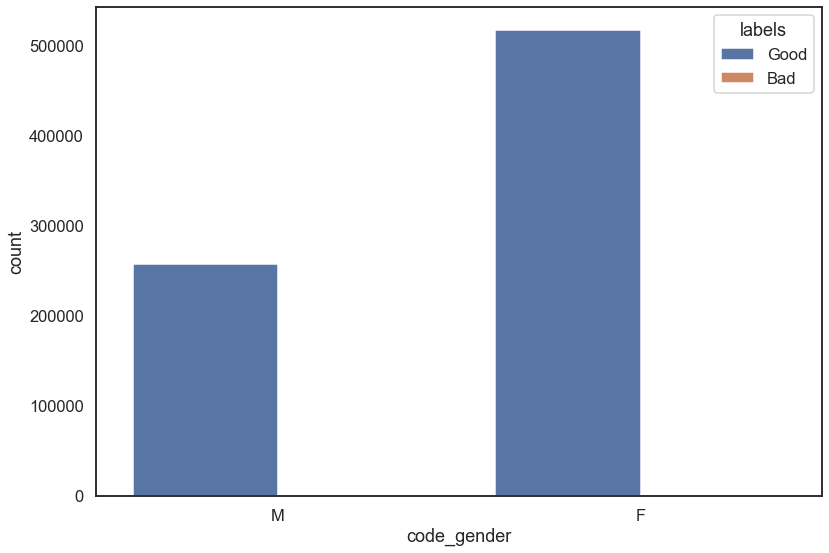

In [16]:
plt.figure(figsize=(13,9))
sns.countplot(x=df['code_gender'], data=df, hue='labels')

In [17]:
#convert some datatypes into their appropriate format
def change_dtypes(df):
    return df.astype('object')
df['flag_email']=change_dtypes(df['flag_email'])
df['flag_work_phone']=change_dtypes(df['flag_work_phone'])
df['flag_phone']=change_dtypes(df['flag_phone'])
df['flag_mobil']=change_dtypes(df['flag_mobil'])

In [18]:
def find_day_of_birth(day_num):
    today = date.today() 
    birthday = (today + timedelta(days=day_num)).strftime('%Y-%m-%d')
    return birthday


In [19]:
df['age']=np.abs(df['days_birth'])//365

In [20]:
def find_employed_date(day_num):
    today = date.today() 
    day_of_employment = (today + timedelta(days=day_num)).strftime('%Y-%m-%d')
    result = 0
    if day_of_employment > today.strftime('%Y-%m-%d') :
         result = 0
    else:
         result = day_of_employment
    return result

In [21]:
df['day_of_employment']=df['days_employed'].apply(lambda x: find_employed_date(x))

In [22]:
df.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,labels,age,day_of_employment
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,Good,32,2010-07-01
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C,Good,32,2010-07-01
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C,Good,32,2010-07-01
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C,Good,32,2010-07-01
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C,Good,32,2010-07-01


In [23]:
cat_columns=[i for i in df.dtypes[df.dtypes=='object'].keys()]
num_columns=[i for i in df.dtypes[df.dtypes!='object'].keys()]

In [24]:
num_columns.remove('id')

In [25]:
num_columns

['cnt_children',
 'amt_income_total',
 'days_birth',
 'days_employed',
 'cnt_fam_members',
 'months_balance',
 'age']

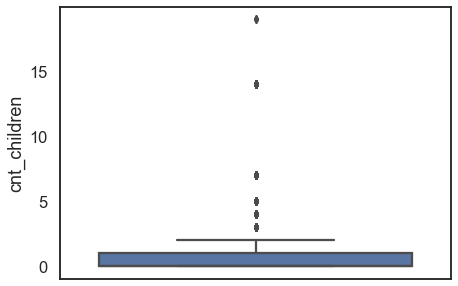

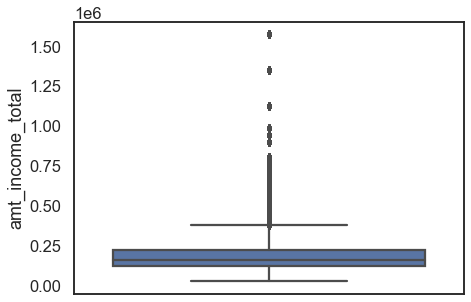

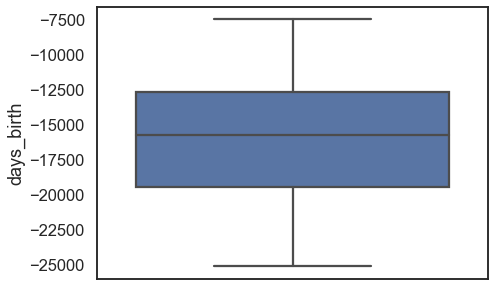

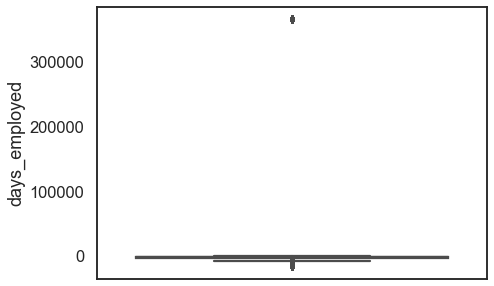

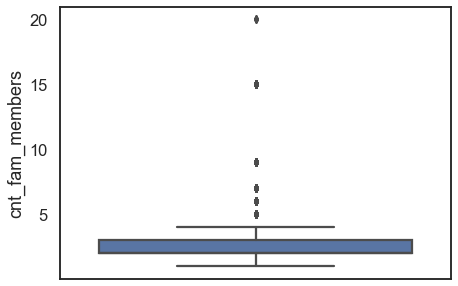

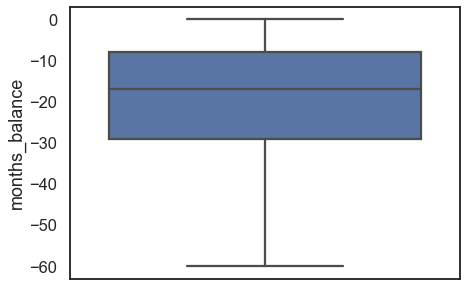

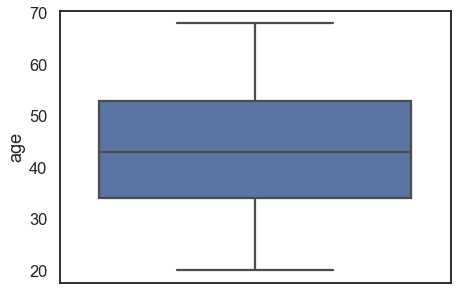

In [26]:
#check for outliers in the numerical columns
for i in num_columns:
    plt.figure(figsize=(7,17))
    plt.subplot(3,1,1)
    sns.boxplot(y=i,data=df)
    

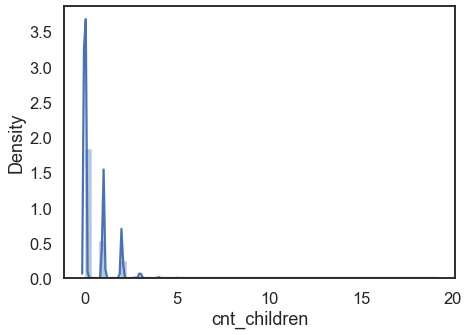

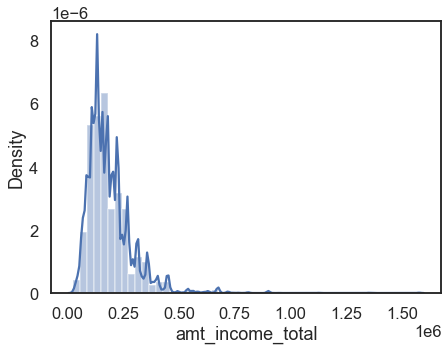

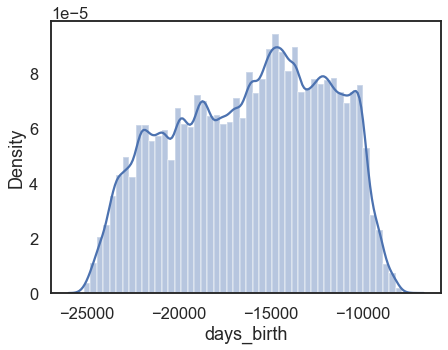

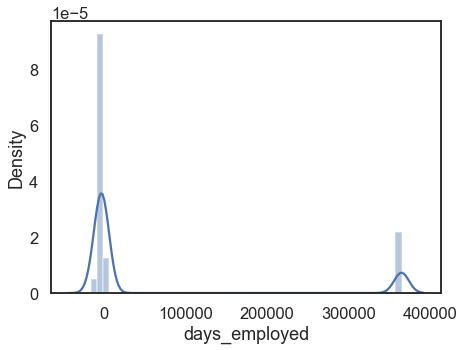

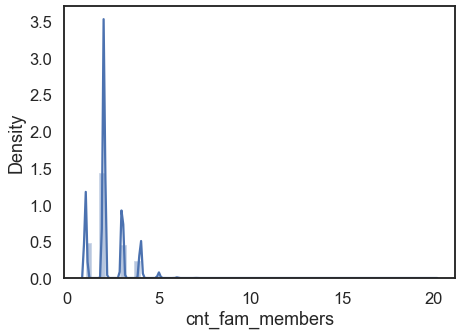

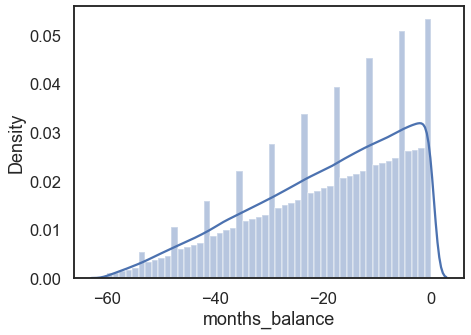

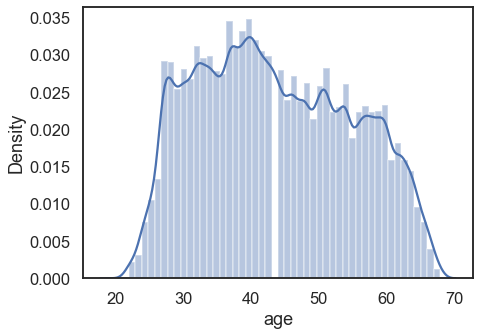

In [27]:

for i in num_columns:
    plt.figure(figsize=(7,17))
    plt.subplot(3,1,1)
    sns.distplot(df[i])
    

In [28]:
df.head(2)

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,labels,age,day_of_employment
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,Good,32,2010-07-01
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C,Good,32,2010-07-01


In [29]:
cat_columns

['code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'flag_mobil',
 'flag_work_phone',
 'flag_phone',
 'flag_email',
 'occupation_type',
 'status',
 'labels',
 'day_of_employment']

### EXPLORATORY DATA ANALYSIS

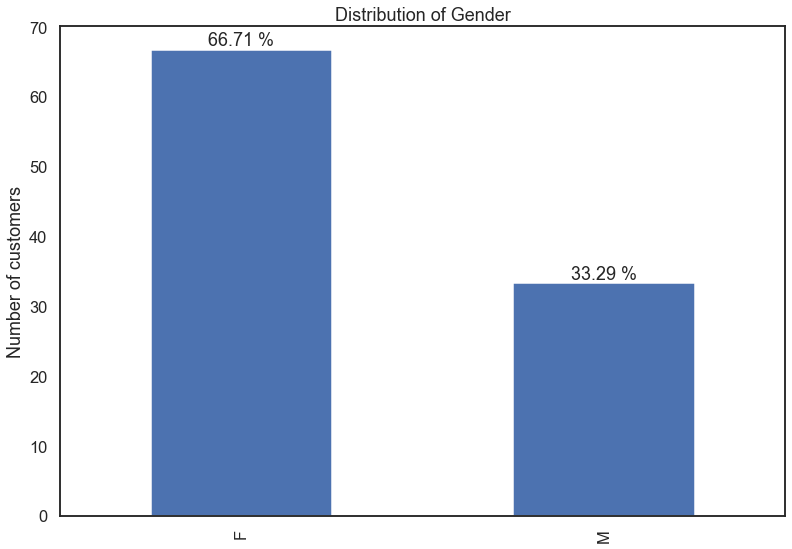

In [30]:
plt.figure(figsize=(13,9))
ax = (df['code_gender'].value_counts()/len(df['code_gender'])*100).plot.bar(rot=90)
ax.bar_label(ax.containers[0], fmt='%.2f %%')
ax.margins(x=12)
plt.ylabel('Number of customers')
plt.title('Distribution of Gender')
plt.show()

Working                 51.453810
Commercial associate    23.579975
Pensioner               16.508875
State servant            8.414008
Student                  0.043332
Name: name_income_type, dtype: float64


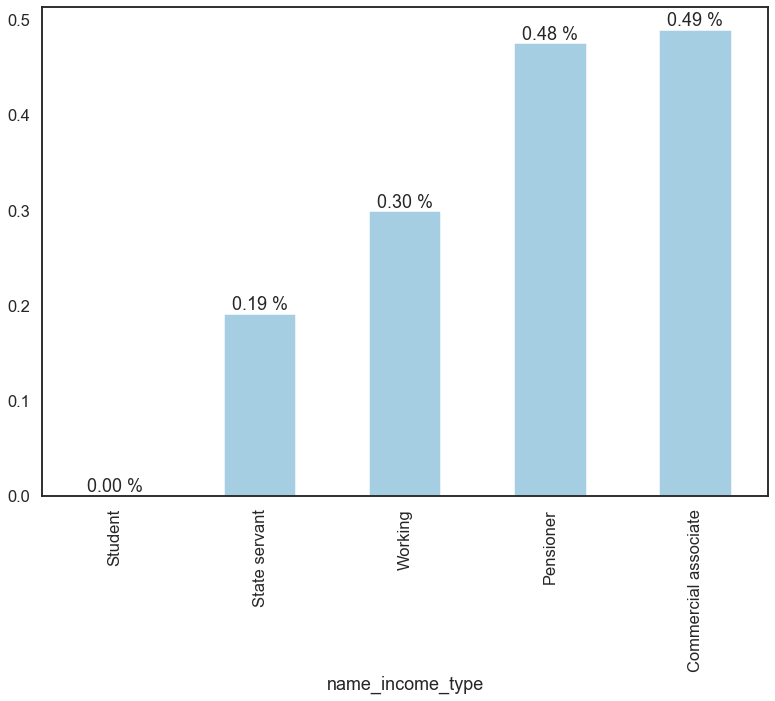

In [31]:
print(df['name_income_type'].value_counts(normalize=True)*100)
plt.figure(figsize=(13,9))
ax=pd.crosstab(df['name_income_type'], df['labels'],normalize='index')['Bad'].mul(100).sort_values(ascending=True).plot(kind='bar',cmap='Paired')
ax.bar_label(ax.containers[0], fmt='%.2f %%');

#### Most individuals are working, with over 50% of individuals, but for all working individuals, only 0.30% of them have bad loans compared to the pensioners, who account for about 17% of the individuals, but have 0.48% of them having bad loans, which suggests the working individuals could be targeted more since they have a low probability of having bad loans


#### 

In [32]:
df.head(2)

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,labels,age,day_of_employment
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,Good,32,2010-07-01
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C,Good,32,2010-07-01


House / apartment      89.640935
With parents            4.594871
Municipal apartment     3.168256
Rented apartment        1.401285
Office apartment        0.724687
Co-op apartment         0.469967
Name: name_housing_type, dtype: float64


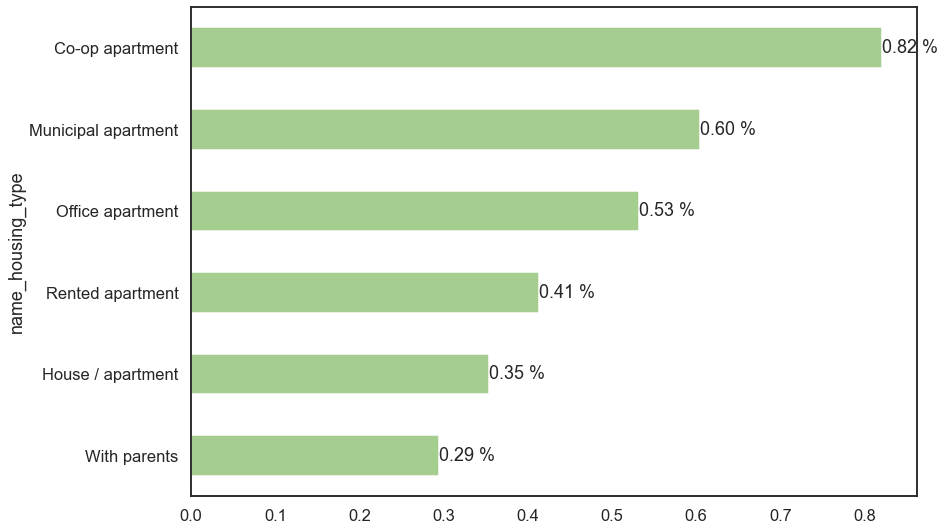

In [33]:
print(df['name_housing_type'].value_counts(normalize=True)*100)
plt.figure(figsize=(13,9))
ax=pd.crosstab(df['name_housing_type'], df['labels'],normalize='index')['Bad'].mul(100).sort_values(ascending=True).plot(kind='barh',cmap='crest')
ax.bar_label(ax.containers[0], fmt='%.2f %%');

#### House/apartment is the housing type that most individuals have, with almost 90% of individuals having a house or apartment, but only 0.35% of all individuals having a house or apartment (2nd lowest) have bad loans. Co-op apartment accounted for only 0.47% of all housing types, but had the most bad loans, with 0.82% of all the 0.47% population with co-op apartment having bad loans

In [34]:
cat_columns

['code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'flag_mobil',
 'flag_work_phone',
 'flag_phone',
 'flag_email',
 'occupation_type',
 'status',
 'labels',
 'day_of_employment']

Married                 70.285259
Single / not married    12.129765
Civil marriage           7.758883
Separated                5.818970
Widow                    4.007123
Name: name_family_status, dtype: float64


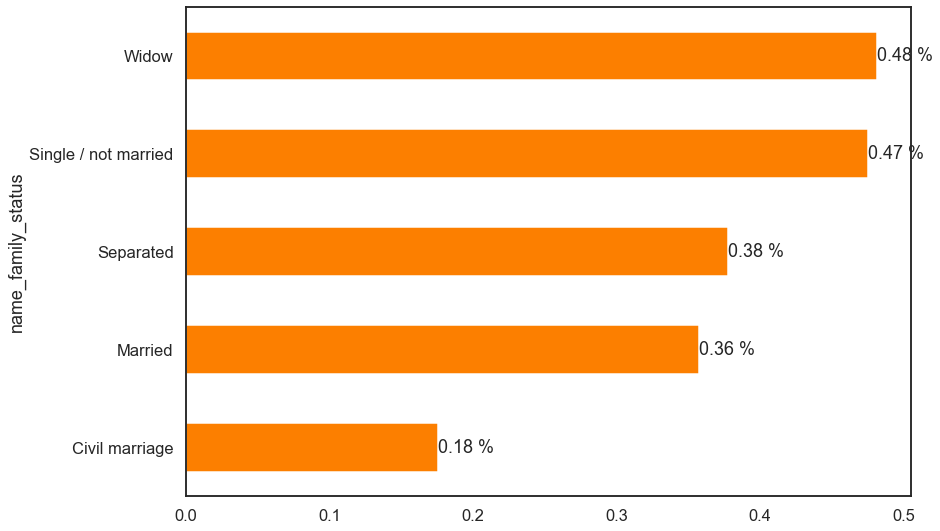

In [35]:
print(df['name_family_status'].value_counts(normalize=True)*100)
plt.figure(figsize=(13,9))
ax=pd.crosstab(df['name_family_status'], df['labels'],normalize='index')['Bad'].mul(100).sort_values(ascending=True).plot(kind='barh',cmap='Wistia_r')
ax.bar_label(ax.containers[0], fmt='%.2f %%');

In [36]:
num_columns

['cnt_children',
 'amt_income_total',
 'days_birth',
 'days_employed',
 'cnt_fam_members',
 'months_balance',
 'age']

In [37]:
df.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,labels,age,day_of_employment
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,Good,32,2010-07-01
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C,Good,32,2010-07-01
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C,Good,32,2010-07-01
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C,Good,32,2010-07-01
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C,Good,32,2010-07-01


In [38]:
selected_cat_cols=['flag_own_car','flag_own_realty','name_income_type','name_education_type',
    'name_family_status','name_housing_type','labels']

for col in df[selected_cat_cols]:
    l_encoder = LabelEncoder()
    df[col]=l_encoder.fit_transform(df[col].values)

In [39]:
df.shape

(777715, 23)

In [40]:
df.head(2)

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,labels,age,day_of_employment
0,5008804,M,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,32,2010-07-01
1,5008804,M,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,NaN,2.0,-1,C,1,32,2010-07-01


In [41]:
num_columns

['cnt_children',
 'amt_income_total',
 'days_birth',
 'days_employed',
 'cnt_fam_members',
 'months_balance',
 'age']

In [42]:
selected_cols = selected_cat_cols + ['amt_income_total','cnt_fam_members','cnt_children']

In [43]:
df_final=df[selected_cols]

In [44]:
X = df_final.drop(columns='labels')
y = df_final['labels']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state =0,stratify=df_final['labels'])

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(622172, 9)
(155543, 9)
(622172,)
(155543,)


In [47]:
scaler = MinMaxScaler()
normalized_X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
normalized_X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

In [48]:
import warnings
warnings.filterwarnings('ignore')

## Predictive Modelling

### Imbalanced Dataset

---------------------
accuracy: 0.9963611348630282
The classification report: 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       566
           1       1.00      1.00      1.00    154977

    accuracy                           1.00    155543
   macro avg       0.50      0.50      0.50    155543
weighted avg       0.99      1.00      0.99    155543



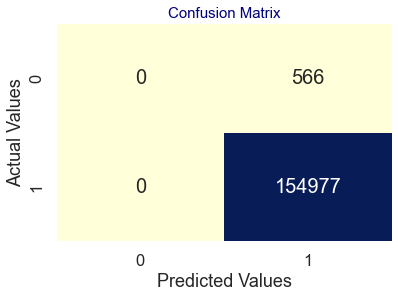

In [49]:
lr=LogisticRegression(random_state=0,solver='lbfgs')
lr.fit(normalized_X_train,y_train)
lr_preds = lr.predict(normalized_X_test)
print('---------------------')
print('accuracy:',accuracy_score(lr_preds, y_test))
sns.heatmap(confusion_matrix(y_test,lr_preds),annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False,cmap='YlGnBu')

plt.title('Confusion Matrix', color='navy', fontsize=15)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

print("The classification report: \n\n {}".format(classification_report(y_test, lr_preds)))

---------------------
accuracy: 0.9964382839472044
The classification report: 

               precision    recall  f1-score   support

           0       0.70      0.04      0.07       566
           1       1.00      1.00      1.00    154977

    accuracy                           1.00    155543
   macro avg       0.85      0.52      0.53    155543
weighted avg       1.00      1.00      0.99    155543



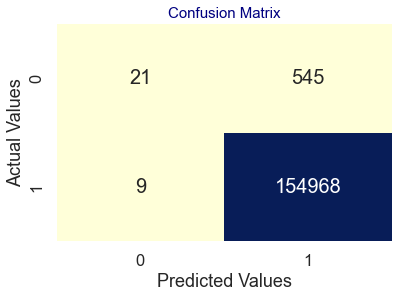

In [50]:
rf = RandomForestClassifier(random_state=0)
rf.fit(normalized_X_train,y_train)
rf_preds = rf.predict(normalized_X_test)
print('---------------------')
print('accuracy:',accuracy_score(rf_preds, y_test))
sns.heatmap(confusion_matrix(y_test, rf_preds),annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False,cmap='YlGnBu')

plt.title('Confusion Matrix', color='navy', fontsize=15)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

print("The classification report: \n\n {}".format(classification_report(y_test, rf_preds)))

#### Training with the unbalanced dataset, from the confusion matrix, it can be seen that what we actually care about, which is the bad loans(signifed as 0 here), none of the individuals were predicted for the logistic regression model, even though the model had an accuracy of about 99.6% for both models, which suggests firstly, accuracy is not a good metric to be used to evaluate unbalanced datasets, and we need to fix this unbalancing in order to capture the individuals with bad loans.

#### The random forest predicted only 21 of such individuals, and had a false negative of 545, individuals that had bad loans but were predicted to have good loans, which is what we are most interested in, because we are interested in minimizing the false negatives, so that we catch a lot of the individuals that have bad loans, hence the recall is key

#### As can be seen, the recall is 0 for logistic regression, and 0.04 for random forest

### Class weight to deal with Imbalance

---------------------
accuracy: 0.6012485293455829
The classification report: 

               precision    recall  f1-score   support

           0       0.01      0.55      0.01       566
           1       1.00      0.60      0.75    154977

    accuracy                           0.60    155543
   macro avg       0.50      0.58      0.38    155543
weighted avg       0.99      0.60      0.75    155543



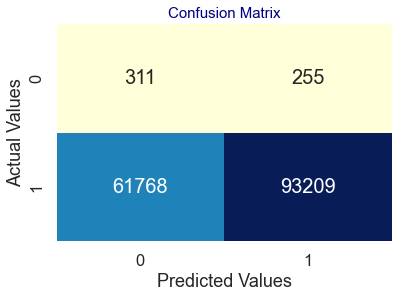

In [51]:
lr=LogisticRegression(random_state=0,solver='lbfgs', class_weight='balanced')
lr.fit(normalized_X_train,y_train)
lr_preds = lr.predict(normalized_X_test)
print('---------------------')
print('accuracy:',accuracy_score(lr_preds, y_test))
sns.heatmap(confusion_matrix(y_test,lr_preds),annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False,cmap='YlGnBu')

plt.title('Confusion Matrix', color='navy', fontsize=15)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

print("The classification report: \n\n {}".format(classification_report(y_test, lr_preds)))

---------------------
accuracy: 0.9053573609869939
The classification report: 

               precision    recall  f1-score   support

           0       0.03      0.87      0.06       566
           1       1.00      0.91      0.95    154977

    accuracy                           0.91    155543
   macro avg       0.52      0.89      0.51    155543
weighted avg       1.00      0.91      0.95    155543



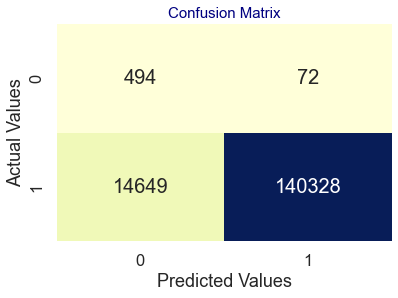

In [52]:
rf = RandomForestClassifier(random_state=0,class_weight='balanced')
rf.fit(normalized_X_train,y_train)
rf_preds = rf.predict(normalized_X_test)
print('---------------------')
print('accuracy:',accuracy_score(rf_preds, y_test))
sns.heatmap(confusion_matrix(y_test, rf_preds),annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False,cmap='YlGnBu')

plt.title('Confusion Matrix', color='navy', fontsize=15)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

print("The classification report: \n\n {}".format(classification_report(y_test, rf_preds)))

#### Using the model to fix the imbalance by adjusting the class weights, originally, all the models had a class weight of 1, but now the models class weight is is balanced, meaning the two classes have the same contribution, which takes care of the imbalance a little, 

#### The logistic regression recall improved from 0 to 0.55, by identifying 311 individuals that had bad loans, and reduced the false negatives from 566 to 255, which is significant
#### The random forest recall improved from 0.04 to 0.87, by identifying 494 individuals that had bad loans, and reduced the false negatives from 545 to 72, which is significant
#### One thing to note is, reducing false negatives, increases false positives, reducing recall, increases precision, so care has to be taken a to the extent of the reduction, as now there are many people that dont have bad loans but the model predicts them to have bad loans, hence a delay and more time wasted making all the checks on such people

### Sampling to deal with imbalance

#### Smote

In [81]:
print("Before OverSampling, counts of label 'Good loan': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label 'Bad loan': {} \n".format(sum(y_train == 0)))

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 0,sampling_strategy=0.7)
X_train_res, y_train_res = sm.fit_resample(normalized_X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label 'Good loan': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label 'Bad loan': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label 'Good loan': 619910
Before OverSampling, counts of label 'Bad loan': 2262 

After OverSampling, the shape of train_X: (1053847, 9)
After OverSampling, the shape of train_y: (1053847,) 

After OverSampling, counts of label 'Good loan': 619910
After OverSampling, counts of label 'Bad loan': 433937


---------------------
accuracy: 0.8926277620979408
The classification report: 

               precision    recall  f1-score   support

           0       0.01      0.20      0.01       566
           1       1.00      0.90      0.94    154977

    accuracy                           0.89    155543
   macro avg       0.50      0.55      0.48    155543
weighted avg       0.99      0.89      0.94    155543



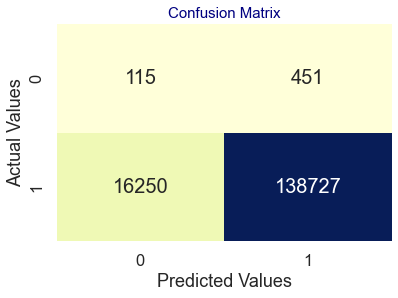

In [54]:
lr=LogisticRegression(random_state=0,solver='lbfgs')
lr.fit(X_train_res,y_train_res.ravel())
lr_preds = lr.predict(normalized_X_test)
print('---------------------')
print('accuracy:',accuracy_score(lr_preds, y_test))
sns.heatmap(confusion_matrix(y_test,lr_preds),annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False,cmap='YlGnBu')

plt.title('Confusion Matrix', color='navy', fontsize=15)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

print("The classification report: \n\n {}".format(classification_report(y_test, lr_preds)))

---------------------
accuracy: 0.9297364715866352
The classification report: 

               precision    recall  f1-score   support

           0       0.04      0.82      0.08       566
           1       1.00      0.93      0.96    154977

    accuracy                           0.93    155543
   macro avg       0.52      0.87      0.52    155543
weighted avg       1.00      0.93      0.96    155543



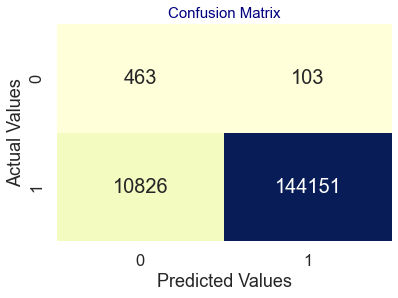

In [55]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_res,y_train_res.ravel())
rf_preds = rf.predict(normalized_X_test)
print('---------------------')
print('accuracy:',accuracy_score(rf_preds, y_test))
sns.heatmap(confusion_matrix(y_test, rf_preds),annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False,cmap='YlGnBu')

plt.title('Confusion Matrix', color='navy', fontsize=15)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

print("The classification report: \n\n {}".format(classification_report(y_test, rf_preds)))

### Intepretability

#### Random Forest

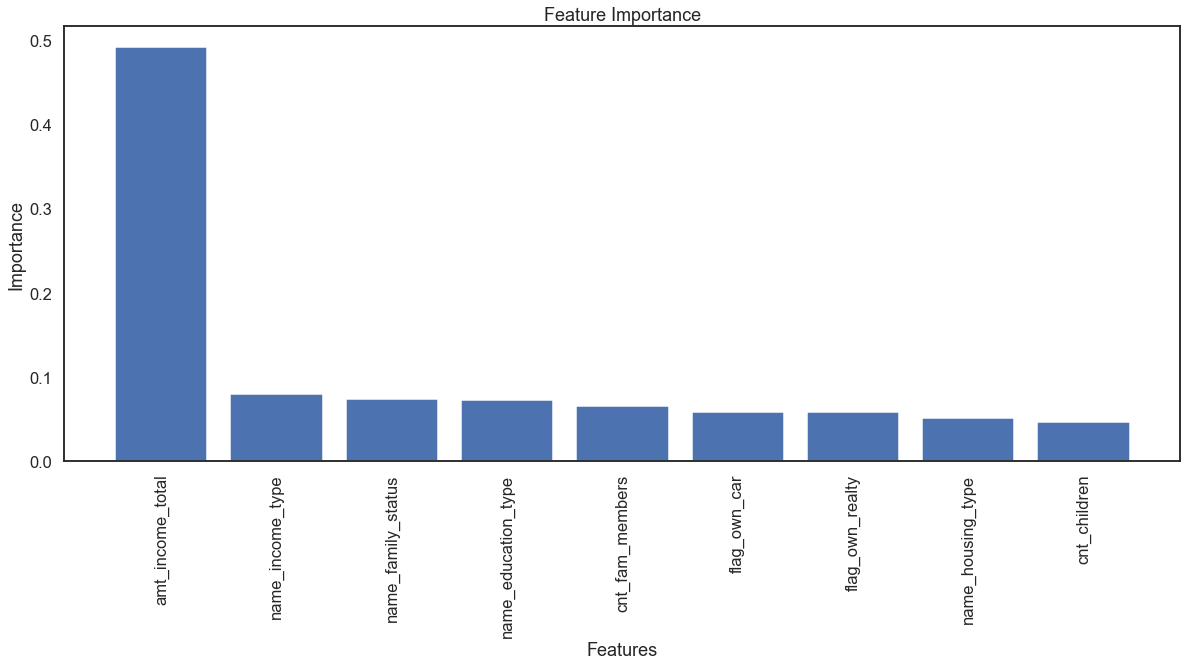

In [75]:
rf = RandomForestClassifier(random_state=0,class_weight='balanced')
rf.fit(normalized_X_train,y_train)
# Calculate feature importances
importances = rf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,8))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')
plt.xlabel('Features')
# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);

#### From the feature importances in the random forest model, the income an indivdual makes is by far the most important in determining if they would be a good or bad loan, and the number of children is the most insignificant

#### Logistic Regression

In [58]:
lr=LogisticRegression(random_state=0,solver='lbfgs')
lr.fit(normalized_X_train,y_train)
d = {'feature': X_train.columns, 'coefficient': lr.coef_[0], 'odds': np.exp(lr.coef_[0])}
lr_explain = pd.DataFrame(data=d)
lr_explain.sort_values(by='odds', ascending=False)

,feature,coefficient,odds
8,cnt_children,1.502255,4.491807
2,name_income_type,0.479250,1.614863
3,name_education_type,0.328035,1.388237
1,flag_own_realty,0.055345,1.056905
5,name_housing_type,-0.022810,0.977448
0,flag_own_car,-0.065460,0.936636
6,amt_income_total,-0.077097,0.925800
4,name_family_status,-0.846779,0.428794
7,cnt_fam_members,-2.496438,0.082378


#### The Logistic regression model considers the number of children as having the most impact to predict bad loans, which is the opposite to the random forest which identified that as the least important

#### An increase in the Number of children(cnt_children) changes (increases) the odds of good loan vs. bad loan by a factor of 4.49, when all other features remain the same

#### If the amt_income_total variable increases by one, the odds of good loan reduces by 7.5 percent.

#### For individuals having their own car(flag_own_car ), the odds for good loan vs. bad loan are by a factor of 0.93 lower, compared to individuals without their own car, given all other features stay the same

